In [1]:
using Pkg; Pkg.activate(".")
include("Leading_boundary.jl")
#Pkg.add(url="https://github.com/VictorVanthilt/TNRKit.jl.git")
using TNRKit

  Activating project at `c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic`


# Benchmarking with the classical Ising model

In [12]:
O = TNRKit.classical_ising(ising_βc);
# @tensor tr_norm = O[1 2;2 1]
tr_norm = exp(rough_lnz(O))
O /= tr_norm
O = InfiniteMPO([O])

┌ Info: Starting simulation
│  TRG - Tensor Renormalization Group
│   * T: TensorMap((ℝ^2 ⊗ ℝ^2) ← (ℝ^2 ⊗ ℝ^2))
│ 
└ @ TNRKit C:\Users\vicva\.julia\packages\TNRKit\6vb9l\src\schemes\tnrscheme.jl:11
┌ Info: Simulation finished
│  Maximum amount of iterations reached: 40
│  Elapsed time: 0.8702369s
│  Iterations: 40
└ @ TNRKit C:\Users\vicva\.julia\packages\TNRKit\6vb9l\src\schemes\tnrscheme.jl:27


single site InfiniteMPO{TensorMap{Float64, CartesianSpace, 2, 2, Vector{Float64}}}:
╷  ⋮
┼ O[1]: TensorMap((ℝ^2 ⊗ ℝ^2) ← (ℝ^2 ⊗ ℝ^2))
╵  ⋮


In [ ]:
χ = 500
L_list = 4:2:16
λ_list = []
λex_list = []

for L in L_list
    @info L
    H = periodic_boundary_conditions(O,L)
    ψ = FiniteMPS(L,ℝ^2,ℝ^χ)
    ψ2 = FiniteMPS(L,ℝ^2,ℝ^χ)
    (ψ, envir , delta) = find_groundstate_alt(ψ, H, DMRG(maxiter = 100,tol=1e-14, eigalg =MPSKit.Defaults.alg_eigsolve(; ishermitian=true)));
    E0 = expectation_value(ψ,H)
    En, state  = excitations_alt(H, FiniteExcited_alt(gsalg = DMRG(maxiter = 100,tol=1e-14,eigalg =MPSKit.Defaults.alg_eigsolve(;ishermitian=true))), (ψ,),(1.0,-E0),init = ψ2,num=1) 
    push!(λ_list,log(E0)/L+log(tr_norm))
    push!(λex_list,log(real(E0/En[1]))*L/(2π))
end

In [41]:
# extra 2 factor from the initial tensor
lnz_onsager = -2*f_onsager * ising_βc

1.859390796683220397580887819556857578217254985933346765831011837555308829905698

In [15]:
λ_list

7-element Vector{Any}:
 1.8754792933671471 - 1.1483322360994153e-17im
  1.866606796162539 + 9.462798761987532e-19im
 1.8634633704196768 - 5.615208820366174e-18im
 1.8620013494581924 - 2.5152965964507956e-18im
 1.8612052457634423 - 1.0330010504557145e-17im
  1.860724558919211 - 3.345869334362827e-18im
 1.8604123063761109 + 7.603157451843647e-18im

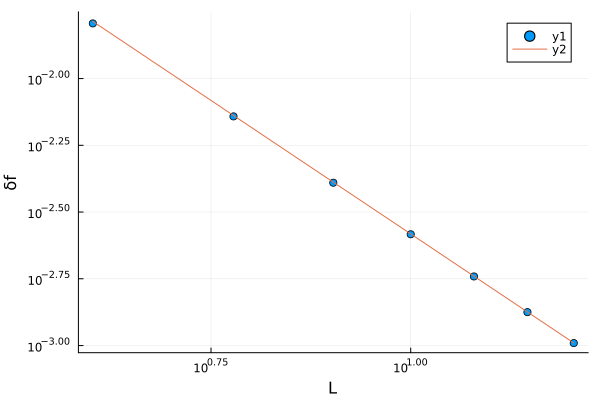

In [16]:
c = 1/2
scatter(L_list,abs.(λ_list.-lnz_onsager),xscale=:log10,yscale=:log10,xlabel="L",ylabel="δf")
plot!(L_list,π*c/6 ./L_list.^2)

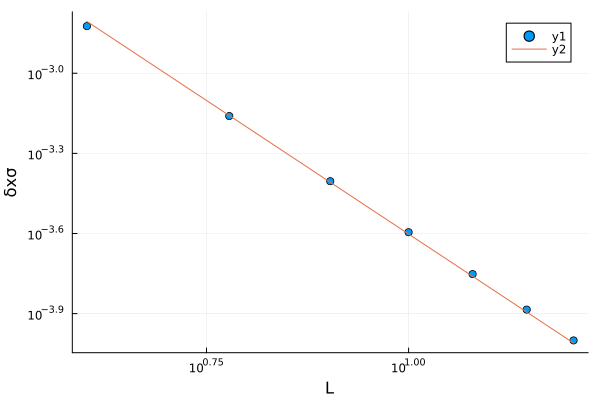

In [17]:
scatter(L_list,abs.(λex_list.-1/8),xscale=:log10,yscale=:log10,xlabel="L",ylabel="δxσ")
plot!(L_list,2.5e-2 ./L_list.^2)

# Non-hermitian Potts model

In [9]:
# legs => (left, bottom, top, right)
function Plaquette_Potts_prev(q::Int64, β, J□;JΔ=0.0)
    V = ℝ^q
    data = Float64[Int(i==j)*Int(j==k) for i=1:q, j=1:q, k=1:q]
    δ3 = TensorMap(data, V ← V ⊗ V)
    U = isometry(fuse(V, V), V ⊗ V)
    A_potts = TensorMap(zeros,Float64, V ⊗ V ← V ⊗ V)
    for i = 1:q
        for j = 1:q
            for k = 1:q
                for l = 1:q
                    # 0.5 factor for double counting the weight on the bond
                    E = -(Int(i == j) + Int(j == k) + Int(k == l) + Int(l == i))/2
                    E -= J□ * Int(i == j == k == l)
                    E -= JΔ * (Int(i==j==k)+Int(j==k==l)+Int(k==l==i)+Int(l==i==j))
                    A_potts[i, j, k, l] = exp(-β * E)
                end
            end
        end
    end
    @tensor Afin[-1 -3;-2 -4] := A_potts[1 2;3 4]*δ3[5;1 11]*conj(δ3[2; 6 7])*conj(δ3[10;3 8])*δ3[4;9 12]*U[-1;5 6]*U[-3;7 8]*conj(U[-4;9 10])*conj(U[-2;11 12]);
    return Afin
end

Plaquette_Potts_prev (generic function with 1 method)

In [ ]:
χ = 500
L_list =  2:1:5
λ_list= []
λex_list = []
q = 3
for L in L_list
    O = Plaquette_Potts_prev(q,log(1+sqrt(q)),0);
    @tensor tr_norm = O[1 2;2 1]
    # tr_norm = exp(rough_lnz(O))
    O /= tr_norm
    O = InfiniteMPO([O,])
    @info L
    H = periodic_boundary_conditions(O,L)
    ψ = FiniteMPS(L,ℝ^(q^2),ℝ^χ)
    ψ2 = FiniteMPS(L,ℝ^(q^2),ℝ^χ)
    (ψ, envir , delta) = find_groundstate_alt(ψ, H, DMRG(maxiter = 100,tol=1e-14, eigalg =MPSKit.Defaults.alg_eigsolve(; ishermitian=true)));
    E0 = expectation_value(ψ,H)
    En, state  = excitations_alt(H, FiniteExcited_alt(gsalg = DMRG(maxiter = 100,tol=1e-14,eigalg =MPSKit.Defaults.alg_eigsolve(;ishermitian=true))), (ψ,),(1.0,-E0),init = ψ2,num=1) 
    push!(λ_list,log(E0)/L+log(tr_norm))
    push!(λex_list,log(real(E0/En[1]))*L/(2π))
end
save_object("gs states rotated 3Potts extra",λ_list)
λex_list = save_object("ex states rotated 3Potts extra",λex_list)


┌ Info: 6
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X13sZmlsZQ==.jl:12
┌ Info: DMRG init:	obj = +1.339651281312e-06	err = 9.7108e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:96
┌ Info: DMRG   1:	obj = +1.339651281312e-06	err = 9.7107710136e-01	time = 37.64 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG   2:	obj = +1.339651281312e-06	err = 9.7107710136e-01	time = 50.79 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117


Looking if the fusing of the two legs is a problem

Any[0.13865079210939266, 0.13225680285912858, 0.1289223278615634, 0.12735340090656333, 0.12656074704860812, 0.12611511604789327]


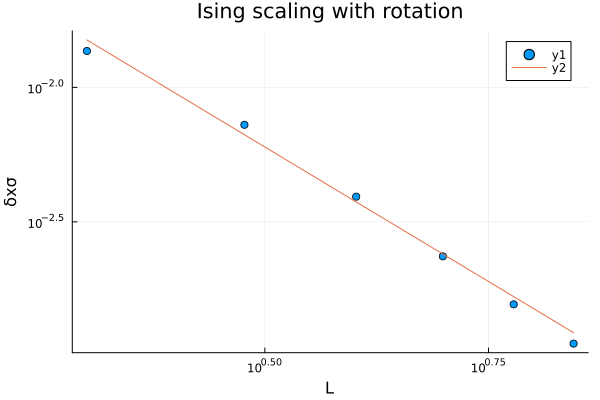

In [ ]:
λex_list = load_object("ex states rotated Ising")
println(λex_list)
scatter(2*L_list,abs.(λex_list.-1/8),xscale=:log10,yscale=:log10,xlabel="L",ylabel="δxσ",title = "Ising scaling with rotation")
plot!(2*L_list,6e-2 ./L_list.^(2))

Any[0.155686533676649, 0.14613256906274666, 0.141135373329418, 0.13868143300088503]


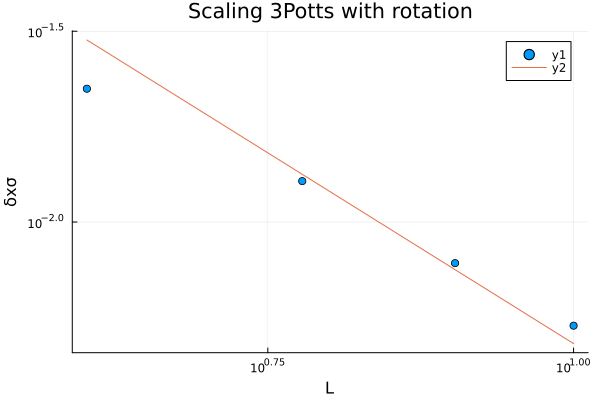

In [2]:
L_list =  2:1:5
λex_list = load_object("ex states rotated 3Potts")
println(λex_list)
scatter(2*L_list,abs.(λex_list.-2/15),xscale=:log10,yscale=:log10,xlabel="L",ylabel="δxσ",title = "Scaling 3Potts with rotation")
plot!(2*L_list,12e-2 ./L_list.^(2))

In [13]:
function Plaquette_Potts(q::Int64, β, J□;JΔ=0.0)
    Vp = Vect[ZNIrrep{q}](sector=>1 for sector in 0:q-1)
    V = ℂ^q
    data = ComplexF64[Int(i==j)*Int(j==k) for i=1:q, j=1:q, k=1:q]
      _,_,W = weyl_heisenberg_matrices(q)
    P   = TensorMap(W,ℂ^q←ℂ^q)
    δ3 = TensorMap(data , V← V ⊗ V)
    δ3 = TensorMap(reshape( (P'*  δ3*(P⊗P)).data,(q,q,q)) , Vp← Vp ⊗ Vp)
    U = isometry(fuse(Vp, Vp), Vp ⊗ Vp)
    A_potts = TensorMap(zeros,ComplexF64, V ⊗ V ← V ⊗ V)
    
    for i = 1:q
        for j = 1:q
            for k = 1:q
                for l = 1:q
                    # 0.5 factor for double counting the weight on the bond
                    E = -(Int(i == j) + Int(j == k) + Int(k == l) + Int(l == i))/2
                    E -= J□ * Int(i == j == k == l)
                    E -= JΔ * (Int(i==j==k)+Int(j==k==l)+Int(k==l==i)+Int(l==i==j))
                    A_potts[i, j, k, l] = exp(-β * E)
                end
            end
        end
    end
    A_potts = TensorMap(reshape(round.(((P'⊗P')*A_potts*(P⊗P)).data,digits = 14),(q,q,q,q)), Vp⊗Vp  ←  Vp⊗Vp)
    @tensor Afin[-1 -2;-3 -4] := A_potts[1 2;3 4]*δ3[5;1 11]*conj(δ3[2; 6 7])*conj(δ3[10;3 8])*δ3[4;9 12]*U[-1;5 6]*U[-2;7 8]*conj(U[-3;9 10])*conj(U[-4;11 12]);
    return A_potts
end

Plaquette_Potts (generic function with 1 method)

In [21]:
χ = 80
L_list = 4:1:12
λ_list = []
λex_list = []
q = 3
for L in L_list
    O = Plaquette_Potts(q,log(1+sqrt(q)),0);
    @tensor tr_norm = O[1 2;2 1]
    O /= tr_norm
    O = InfiniteMPO([O,])
    @info L
    Vp = Vect[ZNIrrep{q}](sector=>1 for sector in 0:q-1)
    Vpp = Vect[ZNIrrep{q}](sector=>χ for sector in 0:q-1)
    H = periodic_boundary_conditions(O,L)
    ψ = FiniteMPS(L,Vp,Vpp)
    ψ2 = FiniteMPS(L,Vp,Vpp)
    # ψ = FiniteMPS(L,ℂ^q,ℂ^χ)
    # ψ2 = FiniteMPS(L,ℂ^q,ℂ^χ)
    (ψ, envir , delta) = find_groundstate_alt(ψ, H, DMRG(maxiter = 100,tol=1e-14, eigalg =MPSKit.Defaults.alg_eigsolve(; ishermitian=true)));
    E0 = expectation_value(ψ,H)
    En, state  = excitations_alt(H, FiniteExcited_alt(gsalg = DMRG(maxiter = 100,tol=1e-14,eigalg =MPSKit.Defaults.alg_eigsolve(;ishermitian=true))), (ψ,),(1.0,-E0),init = ψ2,num=1) 
    push!(λ_list,log(E0)/L+log(tr_norm))
    push!(λex_list,log(real(E0/En[1]))*L/(2π))
end
λ_list = save_object("gs states sym potts3",λ_list)
λex_list = save_object("ex states sym",λex_list)

┌ Info: 4
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:11


(1.0, -0.0685082128305892 + 1.2465968123736566e-15im, -0.003472220804790431 + 2.055662885798789e-16im)


┌ Info: DMRG init:	obj = +3.637104459701e-03 -9.687514751583e-06im	err = 8.7112e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:96
┌ Info: DMRG   1:	obj = +6.850816478615e-02	err = 7.9079339931e-04	time = 0.00 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG conv 2:	obj = +6.850821283059e-02	err = 7.3747762185e-06	time = 0.00 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:111
┌ Info: DMRG init:	obj = -6.398337792870e-03 +6.569575514147e-06im	err = 5.2404e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:96
┌ Info: DMRG   1:	obj = +3.469526617772e-03 +1.561864231382e-07im	err = 1.1960154308e-02	time = 0.01 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG   2:	obj = +3.472119568133e-03 +1.34295377

(1.0, -0.03495723538664822 + 6.9528480296316765e-19im, -0.0018127087086444497 + 1.9820153683644534e-17im)


┌ Info: DMRG   8:	obj = +1.812708708197e-03	err = 1.0577469226e-05	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG conv 9:	obj = +1.812708708469e-03	err = 3.2409661962e-06	time = 0.05 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:111
┌ Info: 6
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:11
┌ Info: DMRG init:	obj = +3.056208785956e-04 +1.384910771490e-06im	err = 8.8625e-01
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:96
┌ Info: DMRG   1:	obj = +1.786632994582e-02 -1.235524158385e-11im	err = 5.3386005083e-04	time = 0.01 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG conv 2:	obj = +1.786633865137e-02	err = 7.2511562635e-06	time = 0.02 s

(1.0, -0.017866338651370852 + 4.5821372972251964e-15im, -0.0009379425794944834 - 4.5475370695812895e-15im)


┌ Info: DMRG   4:	obj = +9.377246632461e-04 -3.484175861390e-09im	err = 4.0825032974e-03	time = 0.01 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG   5:	obj = +9.379364883777e-04 -5.378763991282e-11im	err = 9.6990920424e-04	time = 0.03 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG   6:	obj = +9.379418296765e-04 -3.976905919404e-12im	err = 2.2332613718e-04	time = 0.00 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG   7:	obj = +9.379419570273e-04 +2.111267862444e-13im	err = 5.6499617206e-05	time = 0.01 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG   8:	obj = +9.379420462197e-04 -2.051555052949e-14im	err = 1.1836536528e-05	time = 0.00 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_fo

(1.0, -0.009134168376642299 + 4.027531617042827e-16im, -0.0004832038929092518 + 1.3282025694584834e-14im)


┌ Info: DMRG   9:	obj = +4.832035045310e-04 +3.200871490600e-11im	err = 3.3614213662e-04	time = 0.01 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG  10:	obj = +4.832038454988e-04 +1.518793546956e-12im	err = 1.2218772902e-04	time = 0.02 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG  11:	obj = +4.832038755475e-04 -3.704677445736e-13im	err = 4.0246171866e-05	time = 0.00 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG  12:	obj = +4.832038913235e-04 -7.378542593106e-14im	err = 1.2753960980e-05	time = 0.01 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmech_for_vic\Leading_boundary.jl:117
┌ Info: DMRG conv 13:	obj = +4.832038919298e-04 -1.328202569454e-14im	err = 3.5265252299e-06	time = 0.19 sec
└ @ Main c:\Users\vicva\OneDrive\Documenten\git\Thesis_CCFT\Statmec

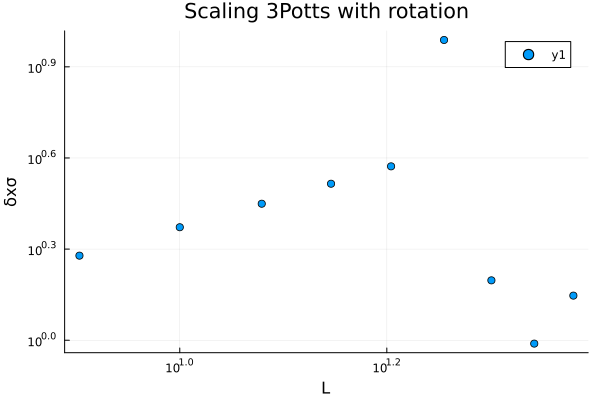

In [22]:
λex_list = load_object("ex states sym")
println(λex_list)
scatter(2*L_list,abs.(λex_list),xscale=:log10,yscale=:log10,xlabel="L",ylabel="δxσ",title = "Scaling 3Potts with rotation")
# plot!(2*L_list,12e-2 ./L_list.^(2))

In [ ]:
using JLD2,Plots
L_list = 4:2:12
# λ_list_p  = load_object("gs states")[1]
λ_list = load_object("gs states sym potts3")
println(λ_list)

# λex_list_p  = load_object("ex states")
# λex_list = load_object("ex states sym")
c = 1/2
# lnz_onsager = -2*f_onsager * ising_βc
p = scatter(2*L_list,abs.(λ_list),xlabel="L",ylabel="E/L",xscale=:log10,yscale=:log10,label="Zq space",title="Scaling for Pottsq3")
#scatter!(2*L_list,abs.(λ_list_p),xlabel="L",ylabel="E/L",label="Original space")
display(p)

In [ ]:
λex_list = load_object("ex states sym")
scatter(L_list,abs.(λex_list.-1/15),xscale=:log10,yscale=:log10,xlabel="L",ylabel="δxσ",label="scaling for Potts q3")